In [2]:
import sys
molgen_path = "../"
if molgen_path not in sys.path:
    sys.path.insert(0, molgen_path)

In [137]:
%load_ext autoreload
%autoreload 2
from rdkit import Chem
from rdkit.Chem import AllChem
from utils import MonomersLib, HELMConverter, draw_mol, get_main_mol, remove_isotopes, is_same_mol

lib = MonomersLib()
monomers_lib_path = molgen_path + "data/helm/library/chembl_35_monomer_library.xml"
lib.load_xml(monomers_lib_path)
monomers_lib_path = molgen_path + "data/helm/library/modan.json"
lib.load_json(monomers_lib_path)
converter = HELMConverter(lib)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[03:05:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[03:05:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[03:05:33] WARNING: not removing hydrogen atom with dummy atom neighbors
[03:05:33] WARNING: not removing hydrogen atom with dummy atom neighbors


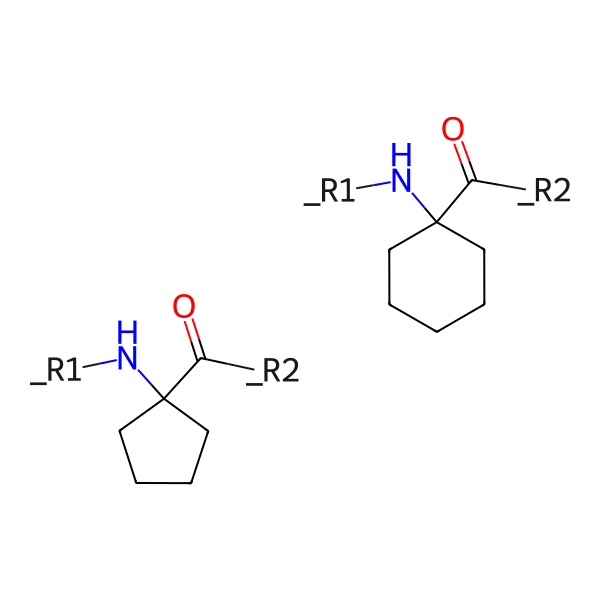

In [138]:
# helm = "PEPTIDE1{[S5Left]}|PEPTIDE1{[S5Right]}|PEPTIDE1{[R8]}|}$$$$"
# helm = "PEPTIDE1{[Aib]}|PEPTIDE1{[Dab]}|PEPTIDE1{[Orn]}|}$$$$"
helm = "PEPTIDE1{[Ac5c]}|PEPTIDE1{[Ac6c]}}$$$$"
# helm = "PEPTIDE1{[OAllylHse]}}$$$$"
# helm = "PEPTIDE1{[Pentanoyl]}|PEPTIDE1{[Dodecanoyl]}|PEPTIDE1{[Octadecanoyl]}}$$$$"
mol = converter._convert(helm, close=False)
draw_mol(mol, 600, 600)

In [139]:
import re

def split_modan_pep_seq(seq: str) -> list[str]:
    pattern = (
        r"("
        r"NH2|X0|X0=|X1|X2|S5|R8"
        r"|H\-|Ac\-|CH3\(CH2\)4CO\-|CH3\(CH2\)10CO\-|CH3\(CH2\)16CO\-"
        r"|[A-Z]"
        r"|[a-z]"
        r")"
    )
    tokens = re.findall(pattern, seq)
    #assert seq == "".join(tokens)
    return tokens

def helm_from_modan_pep_seq(seq: str) -> str:
    #TODO: what is "J"? (placeholder: I)
    token_dict = {"g": "G", #G doesn't have D-form
        "B": "[Ac5c]", "O": "[Orn]", "U": "[Aib]", "Z": "[Ac6c]", "J": "I", 
        "X0": "[OAllylHse]", "X0=": "[OAllylHse]", "X1": "[Dab]", "X2": "[Sar]", 
        "NH2": "[am]", "Ac-": "[ac]",
        "CH3(CH2)4CO-": "[Pentanoyl]", "CH3(CH2)10CO-": "[Dodecanoyl]", "CH3(CH2)16CO-": "[Octadecanoyl]"}
    seq_list = split_modan_pep_seq(seq)
    bridge_left_idx = bridge_right_idx = -1
    monomer_idx = 1
    helm = "PEPTIDE1{"
    for t in seq_list:
        if t == "H-":
            continue
        elif t == "S5":
            if bridge_left_idx == -1:
                bridge_left_idx = monomer_idx
                helm += "[S5Left]."
            else:
                bridge_right_idx = monomer_idx
                helm += "[S5Right]."
        elif t == "R8":
            bridge_left_idx = monomer_idx
            helm += "[R8]"
        else:
            if t in token_dict:
                helm += token_dict[t] + "."
            else:
                if t.isupper():
                    helm += t + "."
                else:
                    helm += "[d" + t.upper() + "]."
        monomer_idx += 1
    if bridge_left_idx == -1:
        helm = helm[:-1] + "}$$$$"
    else:
        helm = helm[:-1] + "}$"
        helm += "PEPTIDE1,PEPTIDE1," + str(bridge_left_idx) + ":R3-" + str(bridge_right_idx) + ":R3$$$"
    return helm

pep_seq = "CH3(CH2)10CO-S5IKKS5LKSAKKFVKAFK-NH2"
#split_modan_pep_seq(pep_seq)
helm_from_modan_pep_seq(pep_seq)

'PEPTIDE1{[Dodecanoyl].[S5Left].I.K.K.[S5Right].L.K.S.A.K.K.F.V.K.A.F.K.[am]}$PEPTIDE1,PEPTIDE1,2:R3-6:R3$$$'

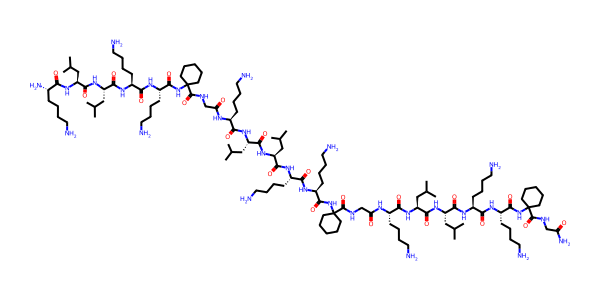

PEPTIDE1{K.L.L.K.K.[Ac6c].G.K.L.L.K.K.[Ac6c].G.K.L.L.K.K.[Ac6c].G.[am]}$$$$


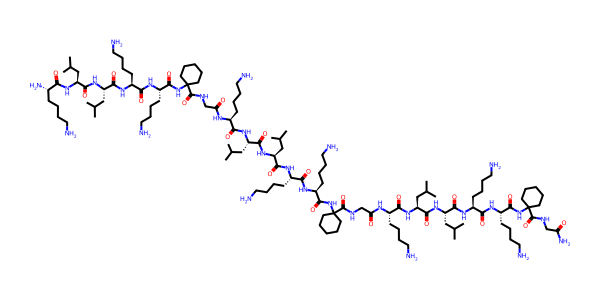

True


In [140]:
width, height = 600, 300
pep, smiles = "H-KLLKKZGKLLKKZGKLLKKZG-NH2", "NC(CNC(C1(CCCCC1)NC([C@H](CCCCN)NC([C@H](CCCCN)NC([C@H](CC(C)C)NC([C@H](CC(C)C)NC([C@H](CCCCN)NC(CNC(C2(CCCCC2)NC([C@H](CCCCN)NC([C@H](CCCCN)NC([C@H](CC(C)C)NC([C@H](CC(C)C)NC([C@H](CCCCN)NC(CNC(C3(CCCCC3)NC([C@H](CCCCN)NC([C@H](CCCCN)NC([C@H](CC(C)C)NC([C@H](CC(C)C)NC([C@H](CCCCN)N)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O"
mol_s = Chem.MolFromSmiles(smiles)
draw_mol(mol_s, width=width, height=height)

helm = helm_from_modan_pep_seq(pep)
print(helm)
mol_h = converter.convert(helm)
draw_mol(mol_h, width=width, height=height)
print(is_same_mol(mol_s, mol_h))

In [141]:
import pandas as pd

modan_raw_path = molgen_path + "data/misc/Dataset_MODAN_initial.xlsx"
df = pd.read_excel(modan_raw_path, sheet_name="Sheet1", index_col=0)

for idx, r in df.iterrows():
    pep = r["Peptide sequence"]
    smiles = r["SMILES"]
    helm = helm_from_modan_pep_seq(pep)
    mol_h = converter.convert(helm)
    mol_s = Chem.MolFromSmiles(smiles)
    if not is_same_mol(mol_h, mol_s):
        print("unmatch: ", idx, pep, smiles)

unmatch:  11 H-KKX0UKKX0U-NH2 [H]N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCOCC=C)C(NC(C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCOCC=C)C(NC(C(N)=O)(C)C)=O)=O)=O)=O)(C)C)=O)=O)=O
unmatch:  12 H-KKX0=UKKX0=U-NH2 [H]N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCOC/C=C\COCC[C@@H](C(NC(C(N)=O)(C)C)=O)NC([C@H](CCCCN)N1)=O)C(NC(C(N[C@@H](CCCCN)C1=O)=O)(C)C)=O)=O)=O
unmatch:  44 H-GIOOFLKSUOOFVOUFO-NH2 [H]NCC(N[C@]([C@@H](C)CC)([H])C(N[C@@H](CCCN)C(N[C@@H](CCCN)C(N[C@H](C(N[C@@H](CC(C)C)C(N[C@@H](CCCN)C(N[C@@H](CO)C(NC(C(N[C@@H](CCCN)C(N[C@@H](CCCN)C(N[C@H](C(N[C@@H](C(C)C)C(N[C@@H](CCCN)C(NC(C(N[C@H](C(N[C@@H](CCCN)C(N)=O)=O)CC1=CC=CC=C1)=O)(C)C)=O)=O)=O)CC2=CC=CC=C2)=O)=O)=O)(C)C)=O)=O)=O)=O)CC3=CC=CC=C3)=O)=O)=O)=O
unmatch:  45 H-GIJJFLJSUJJFVJUFJ-NH2 [H]NCC(N[C@]([C@@H](C)CC)([H])C(N[C@@H](CCN)C(N[C@@H](CCN)C(N[C@H](C(N[C@@H](CC(C)C)C(N[C@@H](CCN)C(N[C@@H](CO)C(NC(C(N[C@@H](CCN)C(N[C@@H](CCN)C(N[C@H](C(N[C@@H](C(C)C)C(N[C@@H](CCN)C(NC(C(N[C@H](C(N[C@@H](CCN)C(N)=O)=O)CC1=CC=CC=C1)=O)(C)C)=O)=